In [32]:
# Finding States of Majorana Chain using DMRG

using ITensors, ITensorMPS, PythonPlot

# Number of states to find
global R = 1

# Length of the spin chain
global L = 12
global sites = siteinds("S=1/2", L)

# Coupling coefficients
global lambdaI = 1
global lambda3 = 1.1

# Number of sweeps, bond dimensions, and cutoff for DMRG algorithm
nsweeps = 20
global maxdim = [10, 33, 66, 133]
global cutoff = 1e-8

# Create the Hamiltonian (HI) of the Ising chain
osI = OpSum()
for j in 1:L
    osI -= "X", j
    osI -= "Z", j, "Z", mod1(j+1, L)
end
HI = MPO(osI, sites)

# Create the Hamiltonian (H3) of the three-spin interaction
os3 = OpSum()
for j in 1:L
    os3 += "X", j, "Z", mod1(j+1, L), "Z", mod1(j+2, L)
    os3 += "Z", j, "Z", mod1(j+1, L), "X", mod1(j+2, L)
end
H3 = MPO(os3, sites)

# Full Hamiltonian
global H = 2 * lambdaI * HI + lambda3 * H3

# Create random initial conditions
psi0 = random_mps(sites)
global psi = Vector{MPS}(undef, R)
global energies = zeros(R)

# Run DMRG algorithm
observer = DMRGObserver(; energy_tol=cutoff)

    # Run once to find a ground state
    println("DMRG Run 1:")
    energies[1], psi[1] = dmrg(H, psi0; nsweeps, maxdim, cutoff, observer=observer)
    println("Final Energy for DMRG Run 1: $(energies[1])")
    println()

    # Find subsequent states while forcing orthogonality
    for i in 2:R
        println("DMRG Run $i:")
        energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, maxdim, cutoff, weight=100, observer=observer)
        println("Final Energy for DMRG Run $i: $(energies[i])")
        println()
    end

# Sort and label the states
global sorted_indices = sortperm(energies)
println("Energy Results from DMRG in Ascending Order:")
for (i, idx) in enumerate(sorted_indices)
    println("State $i: $(energies[idx])")
end

# Analyze probability between states
n_total = length(sorted_indices)
probability_matrix = zeros(ComplexF64, n_total, n_total)
for (i, idx_i) in enumerate(sorted_indices)
    for (j, idx_j) in enumerate(sorted_indices)
        probability_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
    end
end
println("\nNormalizations")
for (i, idx) in enumerate(sorted_indices)
    norm_val = abs(probability_matrix[i,i])
    println("State $i: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=8))")
end
println("\nOverlaps")
for i in 1:n_total
    for j in (i+1):n_total
        probability_val = abs(probability_matrix[i,j])
        println("⟨ψ$(sorted_indices[i])|ψ$(sorted_indices[j])⟩ = $probability_val")
    end
end

DMRG Run 1:
After sweep 1 energy=-23.908980141412417  maxlinkdim=4 maxerr=1.11E-15 time=0.011
After sweep 2 energy=-24.099917500903874  maxlinkdim=16 maxerr=7.07E-09 time=0.011
After sweep 3 energy=-24.10764180897891  maxlinkdim=34 maxerr=9.61E-09 time=0.048
After sweep 4 energy=-24.10787991435989  maxlinkdim=37 maxerr=9.59E-09 time=0.046
After sweep 5 energy=-24.108370121196206  maxlinkdim=37 maxerr=9.56E-09 time=0.044
After sweep 6 energy=-24.109094550448138  maxlinkdim=37 maxerr=9.62E-09 time=0.079
After sweep 7 energy=-24.109922006136145  maxlinkdim=37 maxerr=9.62E-09 time=0.045
After sweep 8 energy=-24.11075465813302  maxlinkdim=37 maxerr=9.38E-09 time=0.047
After sweep 9 energy=-24.111578900847828  maxlinkdim=37 maxerr=9.12E-09 time=0.045
After sweep 10 energy=-24.112364661453103  maxlinkdim=37 maxerr=9.10E-09 time=0.044
After sweep 11 energy=-24.11303709018608  maxlinkdim=37 maxerr=9.09E-09 time=0.046
After sweep 12 energy=-24.113563907861888  maxlinkdim=37 maxerr=9.79E-09 time=

In [33]:
# Initial Conditions

state_idx = 1
sites_idx = 1:length(sites)
global psi0 = psi[sorted_indices[state_idx]]
initial_energy = energies[sorted_indices[state_idx]]
println("Evolving State $state_idx with Energy: $initial_energy")

# Parameters
global w = 100
global T = 2π/w
global N = 50
global n_periods = 40

global drive_lambdaI(t) = lambdaI*cos(w*t)

# Trotter step and total evolution time
global tau = T/N 
global total_time = n_periods * T
global n_steps = n_periods * N
println("Trotter Step Size = $tau")
println("Total Steps = $n_steps")

Evolving State 1 with Energy: -24.115074975647396
Trotter Step Size = 0.0012566370614359175
Total Steps = 2000


In [34]:
# Time Evolution Under Driven Hamiltonian

using LinearAlgebra

# Midpoints of each step
midpoints = [tau*(n + 0.5) for n in 0:(N-1)]

# Build Trotter gates for the Hamiltonian
function build_trotter_gates(sites, tau, t)
    L = length(sites)
    gates = ITensor[]

    current_lambdaI = drive_lambdaI(t)
    
    # Forward sweep
    for j in 1:L
        s1, s2, s3 = sites[j], sites[mod1(j+1, L)], sites[mod1(j+2, L)]
        
        # Build term for Ising part HI
        X_part = -(1/3) * (op("X", s1) * op("Id", s2) * op("Id", s3) +
                           op("Id", s1) * op("X", s2) * op("Id", s3) +
                           op("Id", s1) * op("Id", s2) * op("X", s3))
        ZZ_part = -op("Z", s1) * op("Z", s2) * op("Id", s3)
        HI = X_part + ZZ_part
        
        # Build term for Three-spin part H3
        H3 = op("X", s1) * op("Z", s2) * op("Z", s3) +
             op("Z", s1) * op("Z", s2) * op("X", s3)

        # Define full Hamiltonian and create gate
        H = 2 * current_lambdaI * HI + lambda3 * H3
        push!(gates, exp(-im * tau/2 * H))
    end
    
    # Backward sweep
    append!(gates, reverse(gates))
    return gates
end

# Compute gates for each midpoint in one full period
gate_sets = []
for t_mid in midpoints
    gates = build_trotter_gates(sites, tau, t_mid)
    push!(gate_sets, gates)
end

# Build Time-Dependent Hamiltonian
function H_time(t)
    os = OpSum()
    for j in 1:L
        os += -2 * drive_lambdaI(t), "X", j
        os += -2 * drive_lambdaI(t), "Z", j, "Z", mod1(j+1, L)
        os += lambda3, "X", j, "Z", mod1(j+1, L), "Z", mod1(j+2, L)
        os += lambda3, "Z", j, "Z", mod1(j+1, L), "X", mod1(j+2, L)
    end
    return MPO(os, sites)
end

# Time evolution
psi_evolved = copy(psi0)
times = Float64[]
probability_vals = Float64[]

# Initial conditions
H0 = H_time(0.0)
push!(times, 0.0)
push!(probability_vals, 1.0)

# Time evolution loop which creates unitary U(t)
for step in 1:n_steps

    set_index = mod(step-1, N) + 1
    current_gates = gate_sets[set_index]
    
    # Apply one full Trotter step and normalize
    psi_evolved = apply(current_gates, psi_evolved; cutoff=cutoff, maxdim=maximum(maxdim))
    normalize!(psi_evolved) # psi(t) = U(t)|psi(0)>
    
    # Take measurement at the end of the step
    current_time = step * tau
    if step % 1 == 0 || step == n_steps
        
        # Get Hamiltonian at current time
        H_current = H_time(current_time)
        probability = abs2(inner(psi0, psi_evolved))
        
        # Store for plotting
        push!(times, current_time)
        push!(probability_vals, probability)
    end
end

# Final results
global final_probability = probability_vals[end]

println("Final Probability with Initial State: $(round(final_probability, digits=6))")

Final Probability with Initial State: 0.114683


In [35]:
# Applies an operator 'O' to a wave function
# <psi0|O(0)*O(t)|psi0>

using LinearAlgebra

global O = "Z"

function apply_O(psi, sites, i)
    return apply(op(O, sites[i]), psi)
end

autocorrelation = ComplexF64[]

for i in 1:L
    # |theta> = O*|psi(t)> = O*U(t)|psi(0)>
    theta = apply_O(psi_evolved, sites, i)
    normalize!(theta)

    # |phi(0)> = O*|psi(0)>
    phi = apply_O(psi0, sites, i)
    normalize!(phi)

    # Applies U(t) to |phi>
    for step in 1:n_steps
        set_index = mod(step-1, N) + 1
        current_gates = gate_sets[set_index]

        phi = apply(current_gates, phi; cutoff=cutoff, maxdim=maximum(maxdim))
        normalize!(phi) # |phi(t)> = U(t)*|phi(0)> = U(t)*O*|psi(0)>
    end
    
    push!(autocorrelation, inner(phi, theta))
end

println("Autocorrelation Values:")
for (i, val) in enumerate(autocorrelation)
    println("Site $i: $val")
end

Autocorrelation Values:
Site 1: -0.01663724955797213 - 0.05068480994206839im
Site 2: -0.018380225930291663 - 0.052271995375829904im
Site 3: -0.021210550178946845 - 0.05232605963026793im
Site 4: -0.02155064570495895 - 0.05161496362821973im
Site 5: -0.01903885518885208 - 0.052929294038791985im
Site 6: -0.018472648196405567 - 0.04939611600636433im
Site 7: -0.01750474956608166 - 0.04915396683391906im
Site 8: -0.020473339562686665 - 0.050944713375570314im
Site 9: -0.02103391595100084 - 0.05006475248400747im
Site 10: -0.02046880679123811 - 0.052904677358189565im
Site 11: -0.0187119853154548 - 0.05341849967789467im
Site 12: -0.01637298030825976 - 0.05044533567138745im


In [36]:
# Autocorrelation Components

global real_ac = real.(autocorrelation)
global abs_ac = abs.(autocorrelation)

return nothing


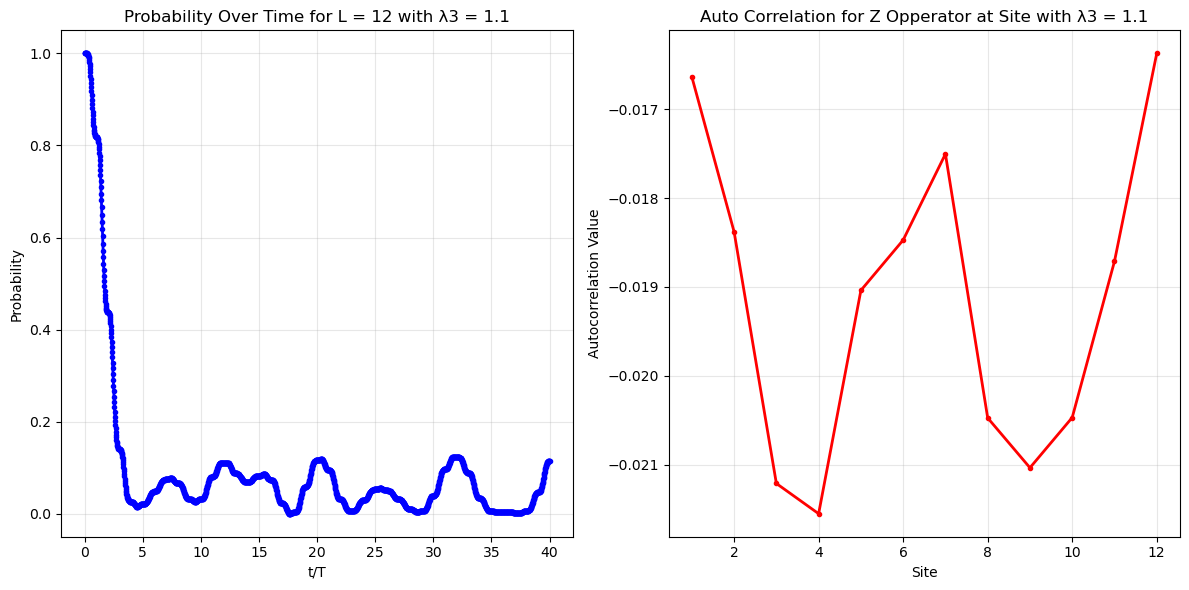

Python: None

In [39]:
# Plotting

fig, (ax1, ax2) = PythonPlot.subplots(1, 2, figsize=(12, 6))
    
    # Probability
    ax1.plot(times/T, probability_vals, "b.-", linewidth=2)
    ax1.set_xlabel("t/T")
    ax1.set_ylabel("Probability")
    ax1.grid(true, alpha=0.3)
    ax1.set_title("Probability Over Time for L = $L with λ3 = $lambda3")
    
    # Autocorrelation
    ax2.plot(sites_idx, real_ac, "r.-", linewidth=2)
    ax2.set_xlabel("Site")
    ax2.set_ylabel("Autocorrelation Value")
    ax2.grid(true, alpha=0.3)
    ax2.set_title("Auto Correlation for $O Opperator at Site with λ3 = $lambda3")

PythonPlot.tight_layout()

PythonPlot.savefig("Probabilit_and_Autocorrelation_for_L=$(L)_lambda3=$(lambda3).png", dpi=300, bbox_inches="tight")

In [38]:
# Print to .csv

using DataFrames, CSV

df1 = DataFrame("time" => times, "return_probability" => probability_vals)
df2 = DataFrame("site" => sites_idx, "autocorrelation" => autocorrelation)

CSV.write("Probability_vs_Time_L=$(L).csv", df1)
CSV.write("Autocorrelation_vs_Site_for_L=$(L).csv", df2)

println("Exported to: Probability_vs_Time_L=$(L)_and_lamdba3=$(lambda3).csv")
println("Exported to: Autocorrelation_vs_Site_for_L=$(L)_O=$(O)_and_lamdba3=$(lambda3).csv")

Exported to: Probability_vs_Time_L=12_and_lamdba3=1.1.csv
Exported to: Autocorrelation_vs_Site_for_L=12_O=Z_and_lamdba3=1.1.csv
